<a id="top"></a>
# Module 4 Project


* Student name: **Will Dougherty**
* Student pace: **self paced**
* Scheduled project review date/time: **17 May 2022, 2:00-2:45 PM**

## Description

In this project I will be be building a recommendation system using the MovieLens dataset.

The overarching task is:

* Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

With this as the core objective, I will expand on this to create a framework for providing recommendations to existing users, as well as new users.

## Business Problem

FlixWeb is a relative newcomer to the online movie-streaming space. Their current platform provides films to users, who rate them, and then those ratings help users find quality films to watch.

However they've received lots of feedback requesting more personalized recommendations, since users often spend a lot of time looking for something to watch, and would like to have more tailored recommendations based on the ratings they've given to films.

* Better recommendations means more user engagement, and they'll be more likely to choose our service to give them interesting suggestions for what to watch.
* Users often want to watch 'something', maybe even with a general parameter in mind ('horror movie', 'classic film') but spend a long time in our app looking around before deciding on what to watch.

As the lead data scientist for FlixWeb, I am tasked with building a recommendation system for existing users. In addition, we need a way to recommend films to new users, and onboard them onto the service, leading to their user profile becoming 'mature' and able to be incorporated into the full model.

## Goals:

1) Since movie ratings are the raw material of the dataset, the model will predict users' ratings. However, the more important measure is how a user would rank a collection of films, as every user is rating films on their own subjective, un-scientific scale. Thus, I will target the highest NDCG (Normalized Discounted Cumulative Gain) across all users in order to maximize the quality of recommendations, as any list of recommended films is itself a predicted ranking.

2) Use these predictions to implement a framework for making recommendations. This will include basic 'Top 5' recommendations, as well as top films in a given genre or decade, and also films that are 'hidden gems' (few rankings).

3) Create a plan for providing recommendations for new users with few or no ratings, and onboard them until their user profile matures.

## Dataset and Methodology

* The MovieLens dataset comes in two sizes: the full set (> 27 million ratings) and a small set (> 100,000 ratings). I will perform EDA on the small set, and based on this, will decide how to either use that dataset, or subset the larger set.

* I will utilize an ALS collaborative filtering approach to build the main model, and will target NDCG to tune and optimize the model. Although I will measure RMSE to determine how closely the model predicts users' ratings, NDCG is a better measure of how accurate the predicted ranking of recommended films will be.

* I will also utilize content-based filtering to deal with cold-start (new) users, to recommend films based on the few films a user has already watched (before user profile completion).

* Finally, I will create a mockup that pulls all of this together, and simulates the user experience of a new user to the service. This will walk through the process of initial recommendations, early content-based filtering, completion of the user profile, and generation of collaborative-filtering recommendations.

# Contents

## 1. [EDA](#eda)
## 2. [Modelling](#model)
## 3. [Implementation](#imp)
## 4. [Conclusions](#conclusion)

*********************
<a id="eda"></a>
# 1. EDA
[Back to Top](#top) | [Next Section](#model)

## 1.1 Importing Packages and Data

* There are only three general dimensions to this dataset: users, movies, and ratings.

* Thus, I will check for missing data, look at distributions, and determine next steps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
%matplotlib inline

In [2]:
links = pd.read_csv('./data/small/links.csv')

movies = pd.read_csv('./data/small/movies.csv')

ratings = pd.read_csv('./data/small/ratings.csv')

tags = pd.read_csv('./data/small/tags.csv')

## 1.2 Basic EDA

* How many unique users / movies?
* What are distributions of users / movies / ratings?

In [3]:
print("Unique users:", len(ratings.userId.unique()))

Unique users: 610


In [4]:
print("Unique films:", len(ratings.movieId.unique()))

Unique films: 9724


In [5]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [6]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


### 1.2.1 User Distribution

In [7]:
users = ratings.userId.unique()
user_counts = np.array([len(ratings[ratings.userId == Id]) for Id in users])
user_stats = pd.DataFrame()
user_stats['userId'] = users
user_stats['count'] = user_counts

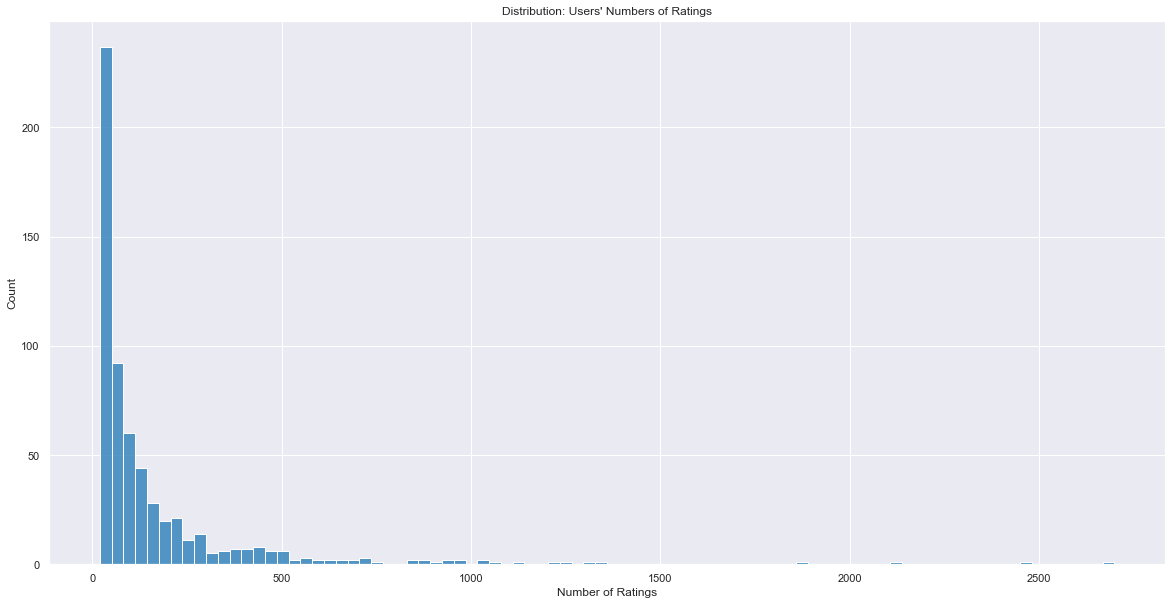

In [8]:
fig = plt.figure(figsize=(20,10))

ax = sns.histplot(data=user_stats, x='count')
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Users' Numbers of Ratings");

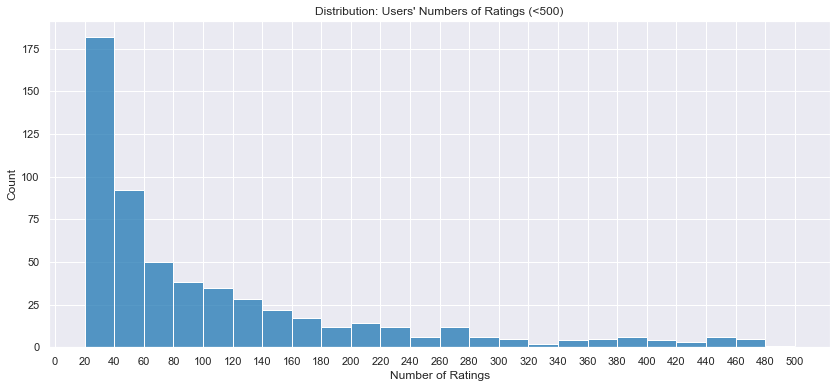

In [9]:
# So most users have less than 500 ratings
# Since there are a lot of very high outliers, let's look at users with <= 500 ratings

fig = plt.figure(figsize=(14,6))

ax = sns.histplot(data=user_stats[user_stats['count'] < 501], x='count', bins=24)
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Users' Numbers of Ratings (<500)")
ax.set_xticks(list(range(0, 501, 20)));

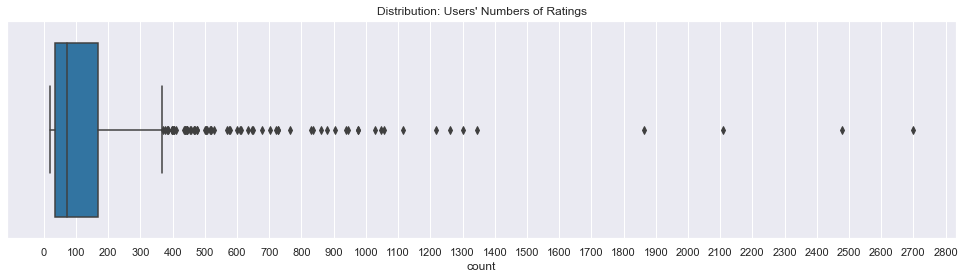

In [10]:
fig = plt.figure(figsize=(17, 4))

ax = sns.boxplot(data=user_stats, x='count')
ax.set_title("Distribution: Users' Numbers of Ratings")
ax.set_xticks(range(0,2801,100));

### 1.2.2 Movie Distribution

In [11]:
uniq_movies = ratings.movieId.unique()
movie_counts = np.array([len(ratings[ratings.movieId == Id]) for Id in uniq_movies])
movie_stats = pd.DataFrame()
movie_stats['movieId'] = uniq_movies
movie_stats['count'] = movie_counts

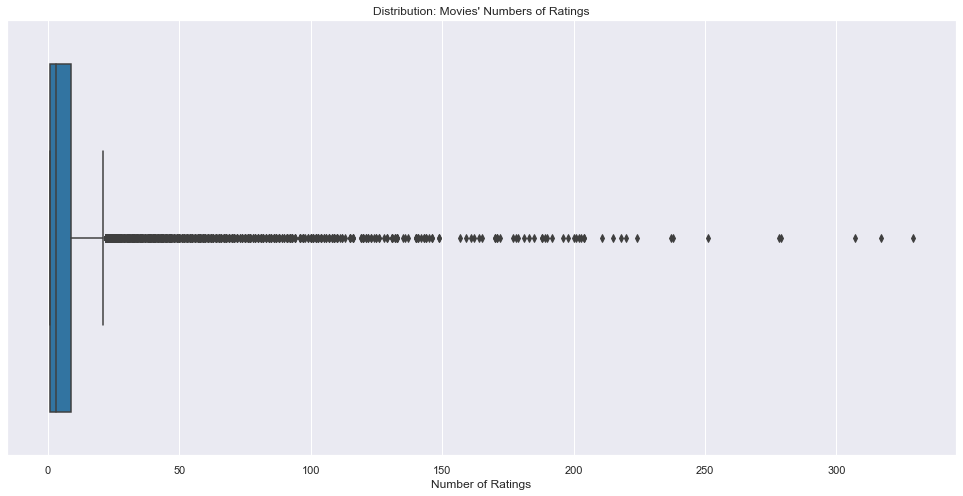

In [12]:
fig = plt.figure(figsize=(17,8))

ax = sns.boxplot(data=movie_stats, x='count')
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Movies' Numbers of Ratings");

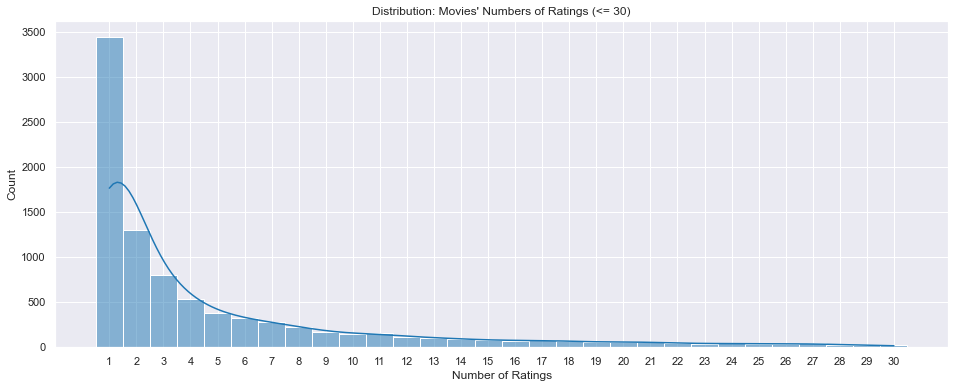

In [13]:
fig = plt.figure(figsize=(16,6))

ax = sns.histplot(data=movie_stats[movie_stats['count'] <= 30], x='count', discrete=True, kde=True)
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Movies' Numbers of Ratings (<= 30)")
ax.set_xticks(range(1,31));

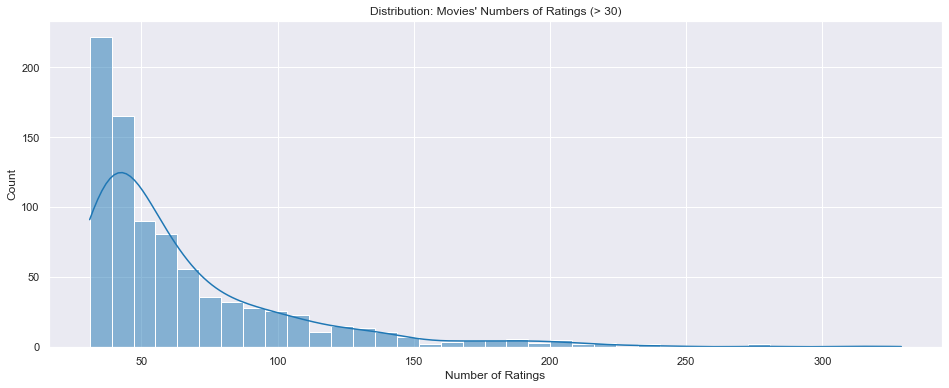

In [14]:
fig = plt.figure(figsize=(16,6))

ax = sns.histplot(data=movie_stats[movie_stats['count'] > 30], x='count', kde=True)
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Movies' Numbers of Ratings (> 30)");
#ax.set_xticks(range(1,31));

### 1.2.3 Movies' Mean Ratings Distribution

In [15]:
movie_avgs = [np.mean(ratings[ratings['movieId'] == Id]['rating']) for Id in uniq_movies]

In [16]:
movie_stats['mean_rating'] = movie_avgs

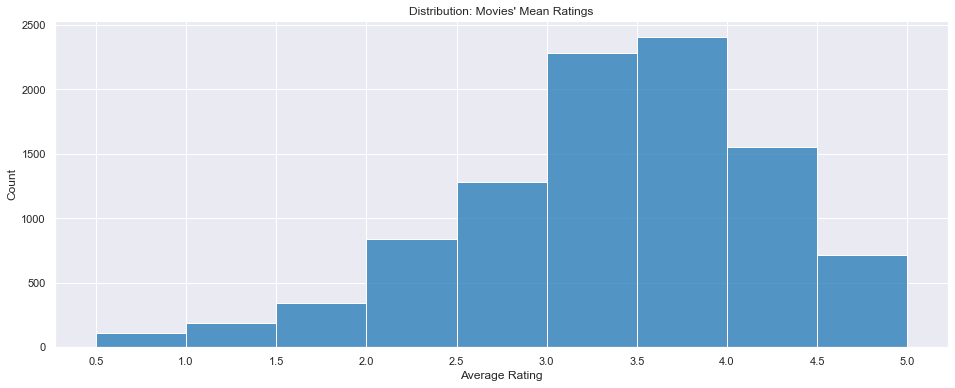

In [17]:
fig = plt.figure(figsize=(16,6))

ax = sns.histplot(data=movie_stats, x='mean_rating', bins=9)
ax.set_xlabel('Average Rating')
ax.set_title("Distribution: Movies' Mean Ratings")
ax.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]);

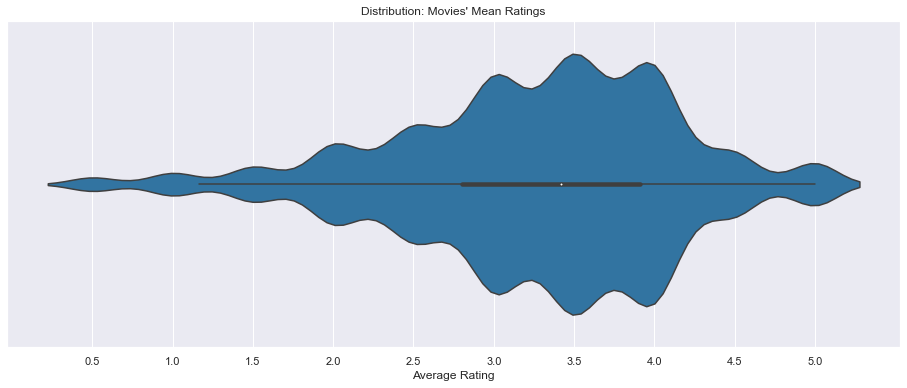

In [18]:
fig = plt.figure(figsize=(16,6))

ax = sns.violinplot(data=movie_stats, x='mean_rating')
ax.set_xlabel('Average Rating')
ax.set_title("Distribution: Movies' Mean Ratings")
ax.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]);

In [19]:
movie_stats.sort_values(by='count', ascending=False)

,movieId,count,mean_rating
20,356,329,4.164134
232,318,317,4.429022
16,296,307,4.197068
34,593,279,4.161290
166,2571,278,4.192446
...,...,...,...
6825,86279,1,3.500000
6826,86922,1,4.000000
857,5962,1,1.000000
6829,87660,1,4.500000


### 1.2.4 Ratings Distribution

In [20]:
rating_stats = pd.DataFrame()
rating_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
rating_stats['rating'] = rating_values
rating_counts = [len(ratings[ratings['rating']==rating]) for rating in rating_values]
rating_stats['count'] = rating_counts

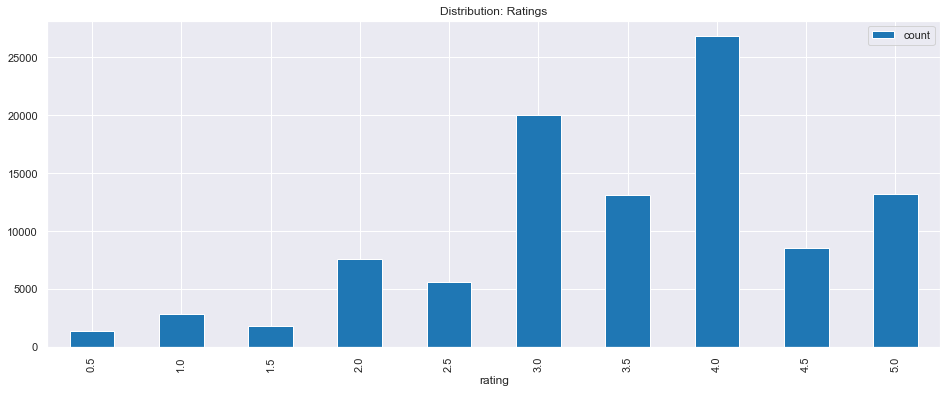

In [21]:
ax = rating_stats.plot(kind='bar', x='rating', y='count', figsize=(16, 6))
ax.set_title('Distribution: Ratings');

In [22]:
def movie_by_id(Id, movie_df):
    return list(movie_df[movie_df['movieId']==Id].title)[0]

movie_by_id(34, movies)

'Babe (1995)'

In [23]:
# Top 20 most-rated

most_rated = movie_stats.sort_values(by='count', ascending=False)

i = 0
while i < 20:
    print(f"#{i+1}:", movie_by_id(most_rated.iloc[i].movieId, movies), "\t", most_rated.iloc[i]['count'], "|",\
          round(most_rated.iloc[i].mean_rating, 1))
    i += 1

#1: Forrest Gump (1994) 	 329.0 | 4.2
#2: Shawshank Redemption, The (1994) 	 317.0 | 4.4
#3: Pulp Fiction (1994) 	 307.0 | 4.2
#4: Silence of the Lambs, The (1991) 	 279.0 | 4.2
#5: Matrix, The (1999) 	 278.0 | 4.2
#6: Star Wars: Episode IV - A New Hope (1977) 	 251.0 | 4.2
#7: Jurassic Park (1993) 	 238.0 | 3.8
#8: Braveheart (1995) 	 237.0 | 4.0
#9: Terminator 2: Judgment Day (1991) 	 224.0 | 4.0
#10: Schindler's List (1993) 	 220.0 | 4.2
#11: Fight Club (1999) 	 218.0 | 4.3
#12: Toy Story (1995) 	 215.0 | 3.9
#13: Star Wars: Episode V - The Empire Strikes Back (1980) 	 211.0 | 4.2
#14: American Beauty (1999) 	 204.0 | 4.1
#15: Usual Suspects, The (1995) 	 204.0 | 4.2
#16: Seven (a.k.a. Se7en) (1995) 	 203.0 | 4.0
#17: Independence Day (a.k.a. ID4) (1996) 	 202.0 | 3.4
#18: Apollo 13 (1995) 	 201.0 | 3.8
#19: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) 	 200.0 | 4.2
#20: Lord of the Rings: The Fellowship of the Ring, The (2001) 	 198.0 | 4.1


In [24]:
# Top 20 highest-rated (with >= 5 ratings)

highest_rated = movie_stats[movie_stats['count'] >= 5].sort_values(by='mean_rating', ascending=False)

i = 0
while i < 20:
    print(f"#{i+1}:", movie_by_id(highest_rated.iloc[i].movieId, movies), "\t", highest_rated.iloc[i]['count'], "|",\
          round(highest_rated.iloc[i].mean_rating, 1))
    i += 1

#1: Trial, The (Procès, Le) (1962) 	 5.0 | 4.9
#2: Three Billboards Outside Ebbing, Missouri (2017) 	 8.0 | 4.8
#3: Memories of Murder (Salinui chueok) (2003) 	 5.0 | 4.7
#4: Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975) 	 6.0 | 4.7
#5: Yi Yi (2000) 	 5.0 | 4.6
#6: Secrets & Lies (1996) 	 11.0 | 4.6
#7: Day of the Doctor, The (2013) 	 7.0 | 4.6
#8: Guess Who's Coming to Dinner (1967) 	 11.0 | 4.5
#9: Paths of Glory (1957) 	 12.0 | 4.5
#10: Paris Is Burning (1990) 	 5.0 | 4.5
#11: Man Bites Dog (C'est arrivé près de chez vous) (1992) 	 6.0 | 4.5
#12: Five Easy Pieces (1970) 	 8.0 | 4.5
#13: Captain Fantastic (2016) 	 5.0 | 4.5
#14: Jules and Jim (Jules et Jim) (1961) 	 5.0 | 4.5
#15: Last Tango in Paris (Ultimo tango a Parigi) (1972) 	 5.0 | 4.5
#16: Last Picture Show, The (1971) 	 8.0 | 4.5
#17: Streetcar Named Desire, A (1951) 	 20.0 | 4.5
#18: Celebration, The (Festen) (1998) 	 12.0 | 4.5
#19: Ran (1985) 	 15.0 | 4.4
#20: Shawshank Redemption, The (19

In [25]:
# Top 20 lowest-rated (>= 5 ratings)

lowest_rated = movie_stats[movie_stats['count'] >= 5].sort_values(by='mean_rating', ascending=True)

i = 0
while i < 20:
    print(f"#{i+1}:", movie_by_id(lowest_rated.iloc[i].movieId, movies), "\t", lowest_rated.iloc[i]['count'], "|",\
          round(lowest_rated.iloc[i].mean_rating, 1))
    i += 1

#1: Police Academy: Mission to Moscow (1994) 	 5.0 | 0.8
#2: Jason X (2002) 	 8.0 | 1.2
#3: When a Stranger Calls (2006) 	 5.0 | 1.3
#4: Problem Child 2 (1991) 	 8.0 | 1.3
#5: Catwoman (2004) 	 9.0 | 1.3
#6: Spice World (1997) 	 10.0 | 1.4
#7: Ernest Goes to Camp (1987) 	 5.0 | 1.4
#8: Jaws 3-D (1983) 	 6.0 | 1.4
#9: Stuart Saves His Family (1995) 	 9.0 | 1.4
#10: Beethoven's 2nd (1993) 	 5.0 | 1.5
#11: Eye of the Beholder (1999) 	 6.0 | 1.6
#12: Ladies Man, The (2000) 	 6.0 | 1.6
#13: My Super Ex-Girlfriend (2006) 	 6.0 | 1.6
#14: Problem Child (1990) 	 12.0 | 1.6
#15: Look Who's Talking Now (1993) 	 6.0 | 1.6
#16: Pokémon the Movie 2000 (2000) 	 6.0 | 1.6
#17: Ghost Rider: Spirit of Vengeance (2012) 	 5.0 | 1.6
#18: Speed 2: Cruise Control (1997) 	 19.0 | 1.6
#19: Flintstones in Viva Rock Vegas, The (2000) 	 12.0 | 1.6
#20: Battlefield Earth (2000) 	 19.0 | 1.7


## 1.3 Conclusions

* There are clear skews and trends in the data distributions.


* Ratings:
    * Most ratings are 3.0 - 4.0
    * Movies with more ratings generally have higher average ratings
* Users:
    * Most users have < 200 ratings, and a large number have close to the minimum (20)
* Movies:
    * Most films have very few ratings, 1/3 have only 1 rating!
    * So most of the ratings are concentrated in films with moderate to large numbers of ratings

*********************
<a id="model"></a>
# 2. Modelling
[Back to Top](#top) | [Previous Section](#eda) | [Next Section](#imp)

Because of findings above:
* Since there are many films (1/3) with only 1 review, I'll subset and create a similiarly sized dataset from the 'full' dataset. I'd like to target:
    * A similar number of ratings as the 'small' dataset (100,000)
    * At least 20 ratings per user (as in the 'small' dataset)
    * At least 5 ratings per film, to weed out very rare/obscure films
    
    
* To evaluate the predictions, I'll use NDCG, which requires that we have relevance scores (in this case, ratings) and evaluate it in a ranked context. To achieve this, I'll subset the large set by:

    * Selecting a subset of users' ratings, for manageability
    * Selecting only ratings of movies with >= 5 ratings
    * Selecting only users with >= 20 ratings of these films
    * Subsetting based on these user/movie rating thresholds again to remove stragglers
    * Setting aside 5 ratings from each user as the Test Set
    * After building model on the remaining ratings, predict ratings for the Test Set movies
    * Finally, calculate NDCG for each user's set of 5 films and calculate mean NDCG across predictions

## 2.1 Data Subsetting

In [26]:
# load full dataset

movies_full = pd.read_csv('./data/full/movies.csv')

ratings_full = pd.read_csv('./data/full/ratings.csv')

* Later on in the project, I ran into the problem of movies' titles not being formatted correctly with their years in parentheses at the end of the title.
* I will address that here by either removing extra spaces at the ends of titles that are otherwise correctly formatted, or removing films with no year present (or no title at all).

In [27]:
good_titles = []
good_ids = []

titles = list(movies_full.title)
movieIds = list(movies_full.movieId)

for i in range(len(titles)):
    if titles[i]:
        if titles[i][-1] == ')':
            if titles[i][-2].isdigit():
                good_titles.append(titles[i])
                good_ids.append(movieIds[i])
        elif titles[i][-2:-1] == ') ':
            if titles[i][-3].isdigit():
                good_titles.append(titles[i][:-1])
                good_ids.append(movieIds[i])

In [28]:
movies_full = movies_full[movies_full['movieId'].isin(good_ids)]
ratings_full = ratings_full[ratings_full['movieId'].isin(good_ids)]

In [29]:
userIds = ratings_full.userId.unique()
print("Number of unique users:", len(userIds))

Number of unique users: 283225


In [30]:
np.random.seed(42)
user_subset = np.random.choice(userIds, replace=False, size=1600)
ratings_subset = ratings_full[ratings_full['userId'].isin(user_subset)]
print("Length of initial subset:", len(ratings_subset))

Length of initial subset: 141082


In [31]:
def subsetter(df, u=20, m=5):
    """
    This function alternates subsetting the dataset by movie rating counts,
    and user rating counts, until it reaches the thresholds.
    
    As it loops, the function prints the type of subsetting and which loop it is on.
    
    Arguments:
        df: dataframe
        u: user rating count threshold (defautl: 20)
        m: movie rating count threshold (default: 5)
    
    Returns:
        subset: subsetted dataframe
    """
    subset = df.copy()
    i = 0
    while ((subset.userId.value_counts().min() < u) or (subset.movieId.value_counts().min() < m)):
        if subset.movieId.value_counts().min() < m:
            print(f"Subsetting by movies, round {i+1}")
            enough = []
            for movie in subset.movieId.unique():
                if len(subset[subset['movieId']==movie]) >= m:
                    enough.append(movie)
            subset = subset[subset['movieId'].isin(enough)]
        if subset.userId.value_counts().min() < u:
            print(f"Subsetting by users, round {i+1}")
            enough = []
            for user in subset.userId.unique():
                if len(subset[subset['userId']==user]) >= u:
                    enough.append(user)
            subset = subset[subset['userId'].isin(enough)]
        i += 1
    return subset

In [32]:
def create_stats(df):
    """
    This function creates two 'stats' dataframes, with count data for each movie and user.
    
    Argument:
        df: dataframe
    
    Returns:
        movie_stats_df, user_stats_df: dataframes with columns for Id (user or movie), and count
    """
    uniq_movies = df.movieId.unique()
    movie_counts = np.array([len(df[df.movieId == Id]) for Id in uniq_movies])
    movie_stats_df = pd.DataFrame()
    movie_stats_df['movieId'] = uniq_movies
    movie_stats_df['count'] = movie_counts

    users = df.userId.unique()
    user_counts = np.array([len(df[df.userId == Id]) for Id in users])
    user_stats_df = pd.DataFrame()
    user_stats_df['userId'] = users
    user_stats_df['count'] = user_counts
    
    return movie_stats_df, user_stats_df

In [33]:
final_subset = subsetter(ratings_subset)

Subsetting by movies, round 1
Subsetting by users, round 1
Subsetting by movies, round 2


In [34]:
final_movie_stats, final_user_stats = create_stats(final_subset)
display(final_movie_stats.sort_values(by='count').head())
display(final_user_stats.sort_values(by='count').head())

,movieId,count
4060,58627,5
3276,1809,5
3266,212,5
3265,93,5
3262,747,5


,userId,count
875,260555,20
585,174979,20
728,216258,20
536,159917,20
639,190641,20


* So we have successfully created the subsetted dataframe, with at least 5 ratings per movie,
* and 20 ratings per user.

* Let's check some stats to confirm it's similar to the 'small' dataset otherwise:

In [35]:
print("Unique films:", len(final_movie_stats))
print("Unique users:", len(final_user_stats))

Unique films: 4061
Unique users: 953


In [36]:
print("Total ratings:", len(final_subset))

Total ratings: 122111


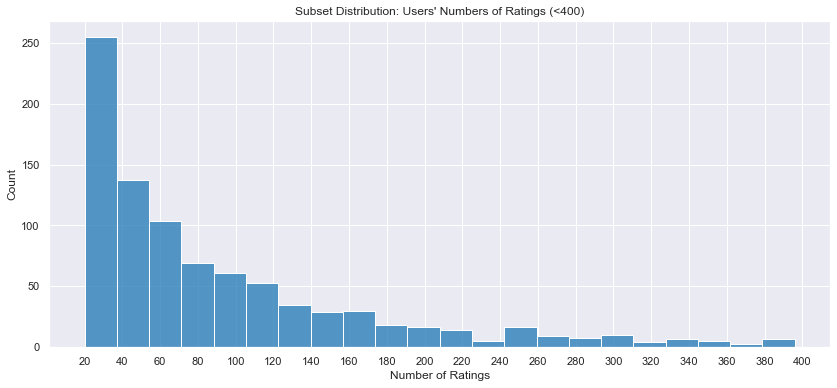

In [37]:
fig = plt.figure(figsize=(14,6))

ax = sns.histplot(data=final_user_stats[final_user_stats['count'] < 400], x='count')
ax.set_xlabel('Number of Ratings')
ax.set_title("Subset Distribution: Users' Numbers of Ratings (<400)")
ax.set_xticks(list(range(20, 401, 20)));

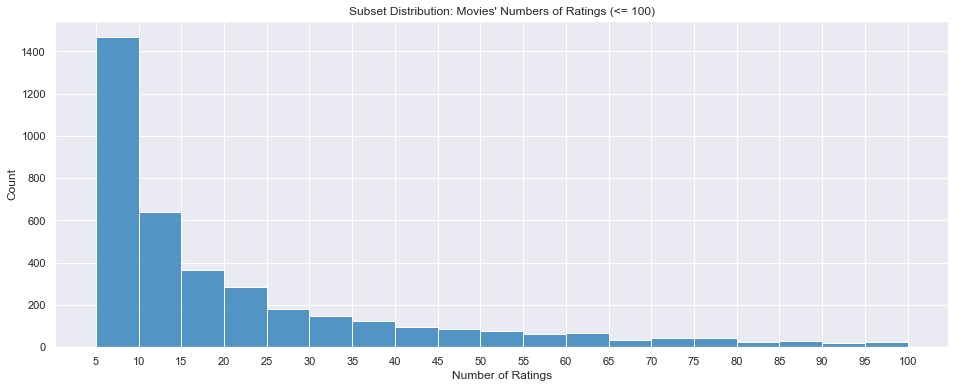

In [38]:
fig = plt.figure(figsize=(16,6))

ax = sns.histplot(data=final_movie_stats[final_movie_stats['count'] <= 100], x='count', bins=19)
ax.set_xlabel('Number of Ratings')
ax.set_title("Subset Distribution: Movies' Numbers of Ratings (<= 100)")
ax.set_xticks(range(5,101,5));

In [39]:
final_movie_stats.describe()

,movieId,count
count,4061.000000,4061.000000
mean,27226.561438,30.069195
std,41627.960170,44.477884
min,1.000000,5.000000
25%,1827.000000,7.000000
50%,4011.000000,14.000000
75%,48322.000000,33.000000
max,187593.000000,486.000000


In [41]:
final_ratings = final_subset.drop(['timestamp'], axis=1).copy()
final_movies = movies_full[movies_full['movieId'].isin(final_movie_stats.movieId)].copy()

In [42]:
from sklearn.model_selection import train_test_split

def split_df(df, n=4, seed=1):
    """
    This function splits a dataframe into train and test dataframes,
    as needed for this project.
    
    By default, it splits each user's ratings 75%-25%, and returns
    ratings dataframes for each.
    
    By using different values for 'seed', the split can be randomized
    for validation purposes.
    """
    userIds = df.userId.unique()
    
    ratings_train = pd.DataFrame()
    ratings_test = pd.DataFrame()
    
    for userId in userIds:
        user_df = df[df['userId']==userId]
        shuffled = user_df.sample(frac=1, random_state=seed)
        result = np.array_split(shuffled, n)

        ratings_train = pd.concat([ratings_train]+result[:-1])
        ratings_test = pd.concat([ratings_test, result[-1]])

        seed += 1
    return ratings_train, ratings_test

In [43]:
# Create the split

ratings_train, ratings_test = split_df(final_ratings)

len(ratings_train), len(ratings_test)

(91916, 30195)

In [44]:
# Setup for visualization of all ratings

# 'flattening' the user / movie IDs - if I just use the actual userId / movieId to plot them,
# the numbers aren't sequential and there would be large gaps/streaks

movieId_flat = {}
userId_flat = {}

movieIds = sorted(list(ratings_train.movieId.unique()))
userIds = sorted(list(ratings_train.userId.unique()))

for Id in enumerate(movieIds):
    movieId_flat[Id[1]] = Id[0]
    
for Id in enumerate(userIds):
    userId_flat[Id[1]] = Id[0]

In [45]:
# Creating dataframe for plotting

ratings_train_temp = ratings_train.copy()

ratings_train_temp['Movie #'] = [movieId_flat[Id] for Id in list(ratings_train['movieId'])]
ratings_train_temp['User #'] = [userId_flat[Id] for Id in list(ratings_train['userId'])]

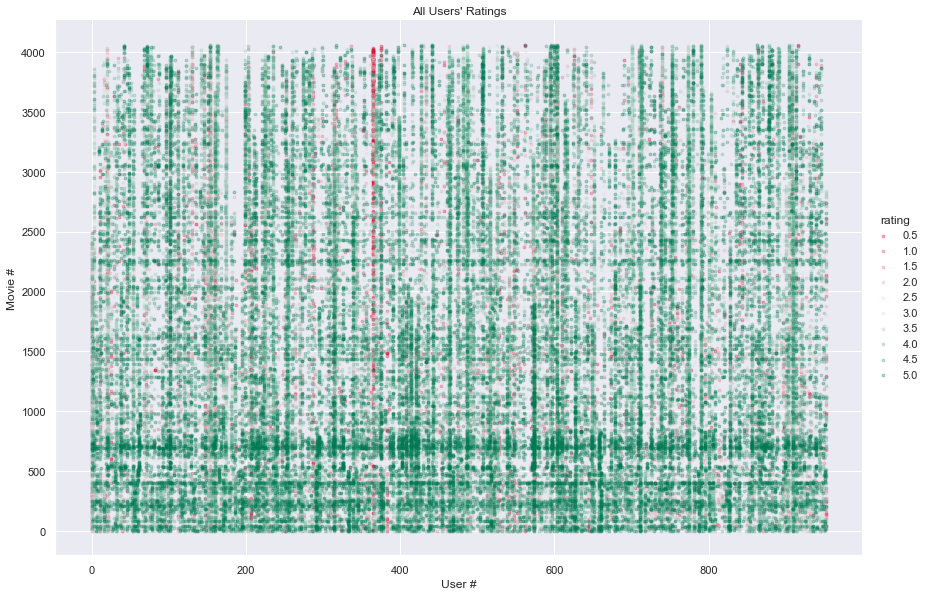

In [46]:
# Plot of all users' ratings, red denoting negative reviews, and green being positive

g = sns.lmplot(x="User #", y="Movie #", hue="rating", data=ratings_train_temp,\
           fit_reg=False, height=8, aspect=1.5, scatter_kws={'alpha':0.3, 's':8},\
           palette=sns.diverging_palette(10, 150, s=100, l=45, sep=1, n=10))
g.ax.set_title("All Users' Ratings");

In [47]:
# Save modified dataframes to .csv

ratings_train.to_csv('./data/ratings_train.csv')
ratings_test.to_csv('./data/ratings_test.csv')
final_ratings.to_csv('./data/ratings_full.csv')
final_movies.to_csv('./data/movies_final.csv')

## 2.2 Create Model

* I will use the pySpark ALS model to generate recommendations.

* First, I will use it on the training set (75% of each user's ratings)

* Tuning and Validation:
    * NDCG, and RMSE (emphasis on NDCG)
    * I will focus on Rank and regParam for hyperparameter tuning

* After finding a 'best' model, I will test it against some baseline techniques for determining users' rankings, to make sure it's better than random chance or using films' average rankings.

### 2.2.1 Setup

In [48]:
# import necessary libraries
from pyspark.sql import SparkSession

# Create pySpark session, and set checkpoint directory (to avoid overflow errors)

spark = SparkSession.builder.appName('RecSys')\
    .config('spark.driver.host', 'localhost')\
    .getOrCreate()

spark.sparkContext.setCheckpointDir('./tmp/checkpoint/')

In [49]:
# Import data into spark dataframes

movies = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load('./data/movies_final.csv')

train = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load('./data/ratings_train.csv')

test = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load('./data/ratings_test.csv')

ratings_full = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load('./data/ratings_full.csv')

In [50]:
# Create pandas version of training set for ease of analysis

train_df = train.toPandas()

In [51]:
# Create a simple DCG function

import math
def dcg(values, k):
    dcg=0
    for i in range(k):
        dcg=dcg+values[i]/math.log(i+2,2)
    return dcg

In [91]:
# Create a function to generate NDCG scores for a given set of predictions

# I'm using NDCG @ k=(1/2 of the length of the user's ratings), to test how well the user's top films are ranked

def NDCG(pred_train, pred_test, return_all=False):
    pred_train_df = pred_train.toPandas()
    pred_test_df = pred_test.toPandas()
    
    userIds = list(pred_test_df.userId.unique())
    
    scores = []
    for i in range(len(userIds)):
        userId = userIds[i]
        
        user_test_df = pred_test_df[pred_test_df['userId']==userId]
        user_train_df = pred_train_df[pred_train_df['userId']==userId]
        user_df = pd.concat([user_test_df, user_train_df])
        
        l1_df = user_df.sort_values(by='prediction', ascending=False)
        l2_df = user_df.sort_values(by='rating', ascending=False)
        l1 = np.array(l1_df['rating'])
        l2 = np.array(l2_df['rating'])

        k = int(len(user_df)/2)
        score = dcg(l1, k) / dcg(l2, k)
        
        scores.append(score)
        
    ndcg = [np.mean(scores), np.max(scores), np.min(scores)]
    
    if return_all:
        return scores
    return ndcg

### 2.2.2 Initial Modelling

In [92]:
# Initial model creation

from pyspark.ml.recommendation import ALS
model = ALS(userCol="userId",itemCol="movieId",ratingCol="rating").fit(train)

In [94]:
# Initial predictions, and calculating NDCG

pred_train = model.transform(train)
pred_test = model.transform(test)
ndcg = NDCG(pred_train, pred_test)
print("Initial model NDCG score:", ndcg[0])

Initial model NDCG score: 0.948455691326608


In [95]:
# Calculating RMSE

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")
print("RMSE:", str(evaluator.evaluate(pred_test.na.drop())))

RMSE: 0.8744035294977506


In [96]:
# Create simple iterator function to test different test/train splits

import numpy as np
def repeatALS (data, k, userCol="userId", itemCol="movieId", ratingCol="rating"):
    rmses = []
    ndcgs = []
    for i in range(1,k+1):
        data_df = data.toPandas()
        tr_df, ts_df = split_df(data_df, seed=i)
        tr = spark.createDataFrame(tr_df)
        ts = spark.createDataFrame(ts_df)
        model = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol,).fit(tr)
        
        pred_train = model.transform(tr)
        pred_test = model.transform(ts)
        ndcg = NDCG(pred_train, pred_test)
        
        evaluator = RegressionEvaluator(metricName='rmse', labelCol="rating", predictionCol="prediction")
        rmse = evaluator.evaluate(pred_test.na.drop())
        
        print("Loop", str(i)+":", 'rmse', "=", str(rmse), '|', 'ndcg:', ndcg[0])
        
        rmses.append(rmse)
        ndcgs.append(ndcg[0])
        
    return [np.mean(rmses), np.mean(ndcgs)]

In [97]:
repeatALS(ratings_full, k=4)

Loop 1: rmse = 0.8744035294977506 | ndcg: 0.948455691326608
Loop 2: rmse = 0.8774136044501837 | ndcg: 0.9494208637508622
Loop 3: rmse = 0.8755750514121412 | ndcg: 0.9487392312697127
Loop 4: rmse = 0.8689453460544359 | ndcg: 0.9486179233072504


[0.8740843828536278, 0.9488084274136083]

In [98]:
# Bespoke grid-search for optimal parameters (pySpark grid-search packages generated errors)

evaluations = []
best = 0
best_params = []

rmses = []
ndcgs = []

for rank in [20, 50, 100]:
    for reg in [.1, .01, .001]:
        print(f"Rank({rank}) reg({reg}) fitting...")
        model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",\
                    rank=rank, maxIter=20, regParam=reg).fit(train)
        
        pred_train = model.transform(train)
        pred_test = model.transform(test)
        
        ndcg = NDCG(pred_train, pred_test)
        
        evaluator = RegressionEvaluator(metricName='rmse', labelCol="rating", predictionCol="prediction")
        rmse = evaluator.evaluate(pred_test.na.drop())
        
        print("rmse =", str(rmse), '|', 'ndcg =', ndcg[0])
        
        evaluations.append([ndcg, rmse, (rank, reg)])
        
        if ndcg[0] > best:
            best = ndcg[0]
            best_params = [rank, reg]
print(f"Best NDCG score: {best}")
print(f"Rank: {best_params[0]}, Reg: {best_params[1]}")

Rank(20) reg(0.1) fitting...
rmse = 0.8675304436876828 | ndcg = 0.9624038747766313
Rank(20) reg(0.01) fitting...
rmse = 1.194035862405591 | ndcg = 0.960181805828715
Rank(20) reg(0.001) fitting...
rmse = 1.5023145697286575 | ndcg = 0.94469426010752
Rank(50) reg(0.1) fitting...
rmse = 0.8593875172055664 | ndcg = 0.97108067603933
Rank(50) reg(0.01) fitting...
rmse = 1.1850487374740095 | ndcg = 0.9747265281331736
Rank(50) reg(0.001) fitting...
rmse = 1.5859347773617374 | ndcg = 0.9642804304690754
Rank(100) reg(0.1) fitting...
rmse = 0.858489320411669 | ndcg = 0.9723984097860684
Rank(100) reg(0.01) fitting...
rmse = 1.1604188760541279 | ndcg = 0.9792956739988595
Rank(100) reg(0.001) fitting...
rmse = 1.704936809502123 | ndcg = 0.9744181354688881
Best NDCG score: 0.9792956739988595
Rank: 100, Reg: 0.01


In [100]:
# Fine-tuning

evaluations = []
best = 0
best_params = []

rmses = []
ndcgs = []

for rank in [100]:
    for reg in [.025, .05, .075]:
        print(f"Rank({rank}) reg({reg}) fitting...")
        model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",\
                    rank=rank, maxIter=20, regParam=reg).fit(train)
        
        pred_train = model.transform(train)
        pred_test = model.transform(test)
        
        ndcg = NDCG(pred_train, pred_test)
        
        evaluator = RegressionEvaluator(metricName='rmse', labelCol="rating", predictionCol="prediction")
        rmse = evaluator.evaluate(pred_test.na.drop())
        
        print("rmse =", str(rmse), '|', 'ndcg =', ndcg[0])
        
        evaluations.append([ndcg, rmse, (rank, reg)])
        
        if ndcg[0] > best:
            best = ndcg[0]
            best_params = [rank, reg]
print(f"Best NDCG score: {best}")
print(f"Rank: {best_params[0]}, Reg: {best_params[1]}")

Rank(100) reg(0.025) fitting...
rmse = 0.9453531224670042 | ndcg = 0.9809800039948459
Rank(100) reg(0.05) fitting...
rmse = 0.8765708284191597 | ndcg = 0.9805315004494013
Rank(100) reg(0.075) fitting...
rmse = 0.8624485809382718 | ndcg = 0.9778913983416927
Best NDCG score: 0.9809800039948459
Rank: 100, Reg: 0.025


* There isn't a 'best' set of parameters that minimizes RMSE and maximizes NDCG, but the rank=100 and regParam=0.05 is a reasonable compromise, with only a slightly higher-than-optimal RMSE and a just slightly lower-than-optimal NDCG.

In [101]:
# Build a best model, train it on the training set, and create predictions

best_model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",\
                rank=100, regParam=0.05, maxIter=20).fit(train)

pred_train = model.transform(train)
pred_test = model.transform(test)

pred_train_df = pred_train.toPandas()
pred_test_df = pred_test.toPandas()

In [102]:
# Calculate NDCG metrics

ndcg_best_model = NDCG(pred_train, pred_test, return_all=True)

ndcg_mean = np.mean(ndcg_best_model)
ndcg_max = np.max(ndcg_best_model)
ndcg_min = np.min(ndcg_best_model)

print("NDCG min score:", ndcg_min)
print("NDCG max score:", ndcg_max)
print("NDCG average score:", ndcg_mean)

NDCG min score: 0.8960978919110546
NDCG max score: 1.0
NDCG average score: 0.9778913983416927


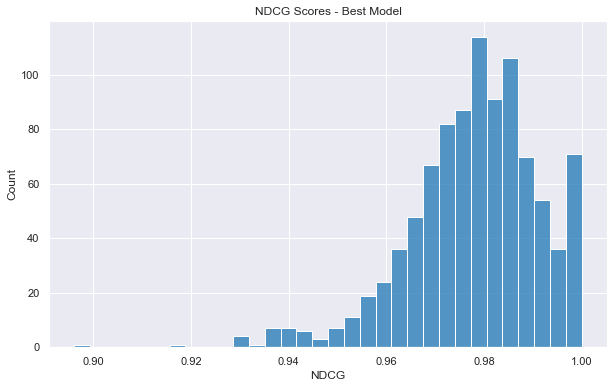

In [108]:
# Show distribution of scores

plt.figure(figsize=(10,6))
ax = sns.histplot(ndcg_best_model)
#ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xlabel('NDCG')
ax.set_title('NDCG Scores - Best Model');

* Now I'll check that the model performs better than other baseline rankings.
    * A random shuffle of the user's rank order
    * Using movies' average ratings to predict a user's rank order

In [104]:
ndcg_random = []

userIds = list(pred_test_df.userId.unique())

for i in range(len(userIds)):
    userId = userIds[i]
    
    user_test_df = pred_test_df[pred_test_df['userId']==userId]
    user_train_df = pred_train_df[pred_train_df['userId']==userId]
    user_df = pd.concat([user_train_df, user_test_df])
    
    l1_df = user_df.sample(frac=1, random_state=i+1)
    l2_df = user_df.sort_values(by='rating', ascending=False)
    l1 = list(l1_df['rating'])
    l2 = list(l2_df['rating'])
    k = int(len(l1)/2) - 1
    
    ndcg = dcg(l1, k) / dcg(l2, k)
    ndcg_random.append(ndcg)
    
ndcg_mean = np.mean(ndcg_random)
ndcg_max = np.max(ndcg_random)
ndcg_min = np.min(ndcg_random)

In [105]:
print(ndcg_mean, ndcg_max, ndcg_min)

0.8105548778760422 1.0 0.3847342323519611


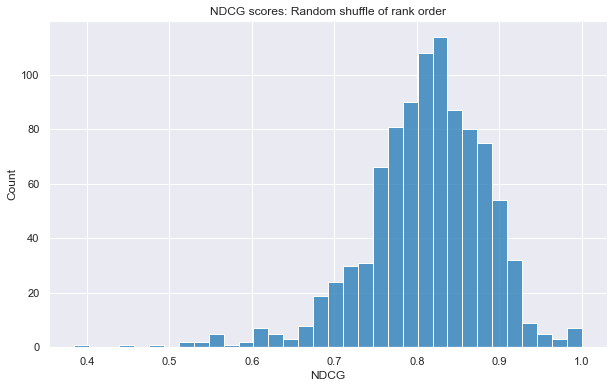

In [106]:
plt.figure(figsize=(10,6))
ax = sns.histplot(ndcg_random)
#ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xlabel('NDCG')
ax.set_title('NDCG scores: Random shuffle of rank order');

In [109]:
movieId_means = {}
for movieId in pred_train_df.movieId.unique():
    sub_df = ratings_train[ratings_train['movieId']==movieId]
    movieId_means[movieId] = sub_df['rating'].mean()

pred_test_df['movie_avg_rating'] = [movieId_means[movieId] for movieId in pred_test_df['movieId']]
pred_train_df['movie_avg_rating'] = [movieId_means[movieId] for movieId in pred_train_df['movieId']]

In [110]:
ndcg_avg = []

userIds = list(pred_test_df.userId.unique())

for i in range(len(userIds)):
    userId = userIds[i]
    user_test_df = pred_test_df[pred_test_df['userId']==userId]
    user_train_df = pred_train_df[pred_train_df['userId']==userId]
    user_df = pd.concat([user_train_df, user_test_df])
    
    l1_df = user_df.sort_values(by='movie_avg_rating', ascending=False)
    l2_df = user_df.sort_values(by='rating', ascending=False)
    l1 = list(l1_df['rating'])
    l2 = list(l2_df['rating'])
    k = int(len(l1)/2) - 1
    
    ndcg = dcg(l1, k) / dcg(l2, k)
    ndcg_avg.append(ndcg)
    
ndcg_mean = np.mean(ndcg_avg)
ndcg_max = np.max(ndcg_avg)
ndcg_min = np.min(ndcg_avg)

In [111]:
print(ndcg_mean, ndcg_max, ndcg_min)

0.8897155104561254 1.0 0.1729095306820655


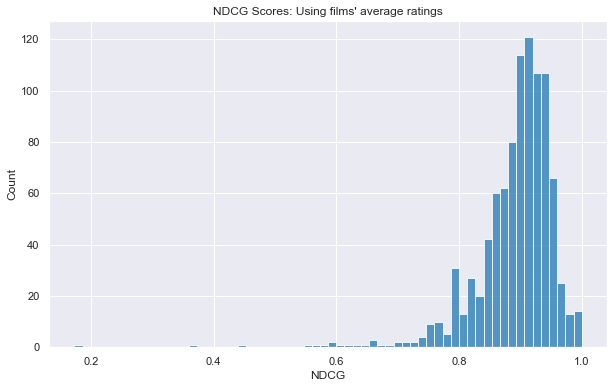

In [112]:
plt.figure(figsize=(10,6))
ax = sns.histplot(ndcg_avg)
#ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xlabel('NDCG')
ax.set_title("NDCG Scores: Using films' average ratings");

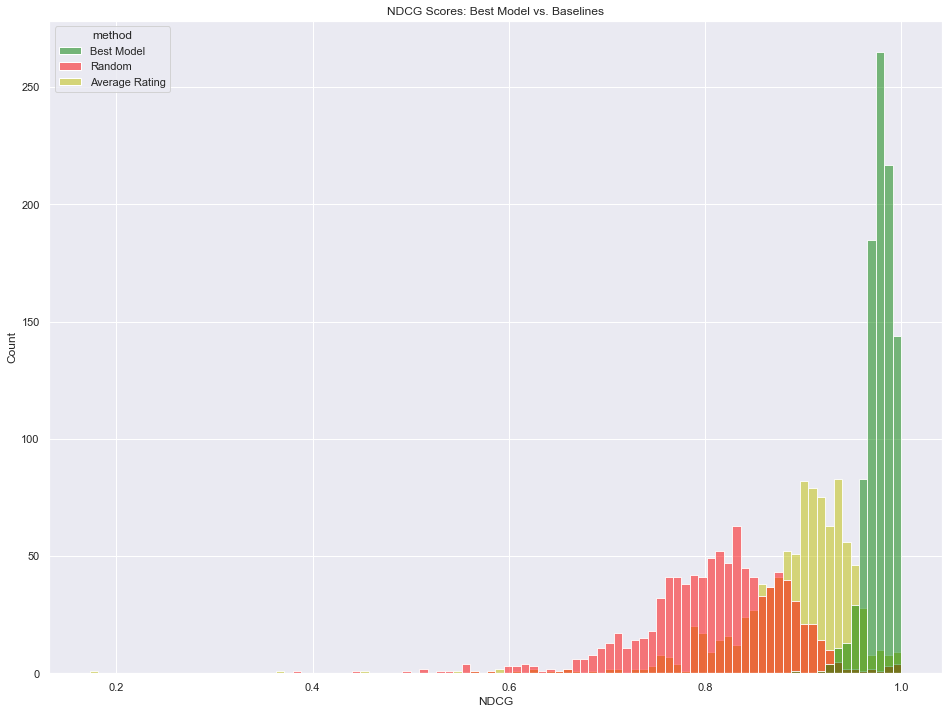

In [113]:
len_ndcg = len(ndcg_best_model)

all_scores = ndcg_best_model + ndcg_random + ndcg_avg

all_scores_dict = {'score':all_scores}

labels = ['Best Model']*len_ndcg + ['Random']*len_ndcg + ['Average Rating']*len_ndcg

all_scores_dict['method'] = labels

all_scores_df = pd.DataFrame(all_scores_dict)

plt.figure(figsize=(16,12))
ax = sns.histplot(data=all_scores_df, x='score', hue='method', bins=96, palette=['g','r','y'])
ax.set_xlabel('NDCG')
ax.set_title("NDCG Scores: Best Model vs. Baselines");

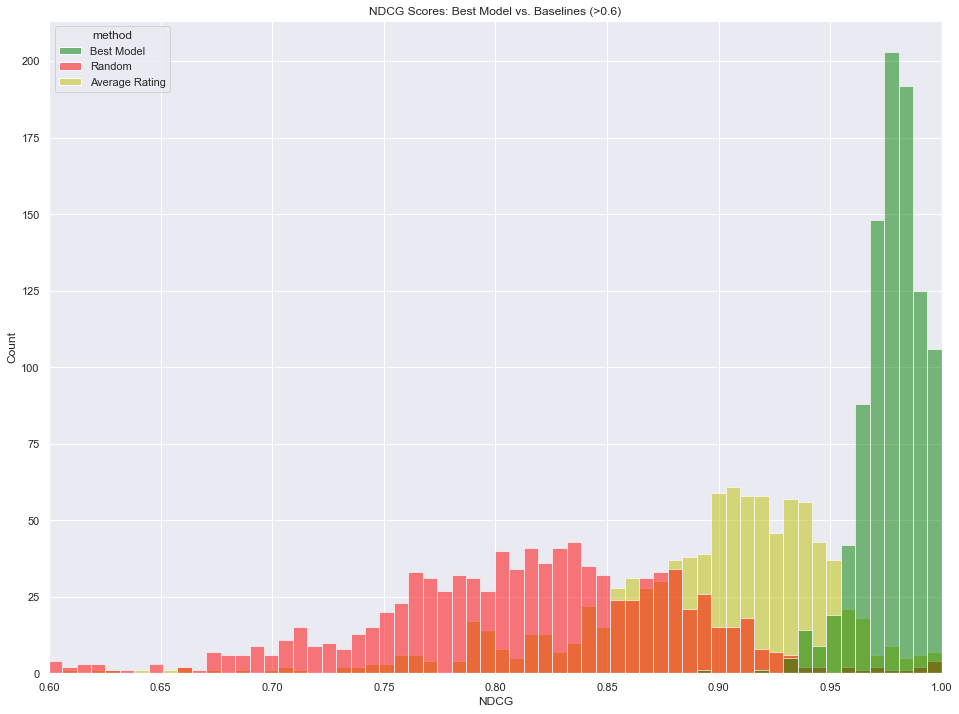

In [114]:
plt.figure(figsize=(16,12))
ax = sns.histplot(data=all_scores_df, x='score', hue='method', bins=128, palette=['g','r','y'])
ax.set_xlabel('NDCG')
ax.set_title("NDCG Scores: Best Model vs. Baselines (>0.6)");
ax.set_xlim(0.6,1.0);

* So we can see that both baseline models have fairly high NDCG scores themselves, which is expected for a few reasons:
    * Most users rank most things in a narrow band (3-4) so the relevance scores can be the same for multiple movies
    * Most users probably also rank somewhat in line with average ratings of films
    
    
* This explains the results of the baseline versions:
    * Random shuffle has an average NDCG of 0.81, and is roughly normally distributed within around .2 units
    * Using the average rating is better, with an average NDCG of .89, but is also roughly normally distributed with a large left-skew
    * However, the actual model NDCG scores are much better - many users had a 'perfect' 1.0 score, and the lowest score was the same as the average for the average-rating version.
    * As well, the distribution seems to normally distributed as well, but with the peak being very narrow, and very close to 1.0

As a final check of the modelling data, before implementing, I want to check how the NDCG scores line up with a user's rating count.

In [115]:
counts_best_model = []
for userId in list(pred_train_df.userId.unique()):
    counts_best_model.append(len(pred_train_df[pred_train_df['userId']==userId]))

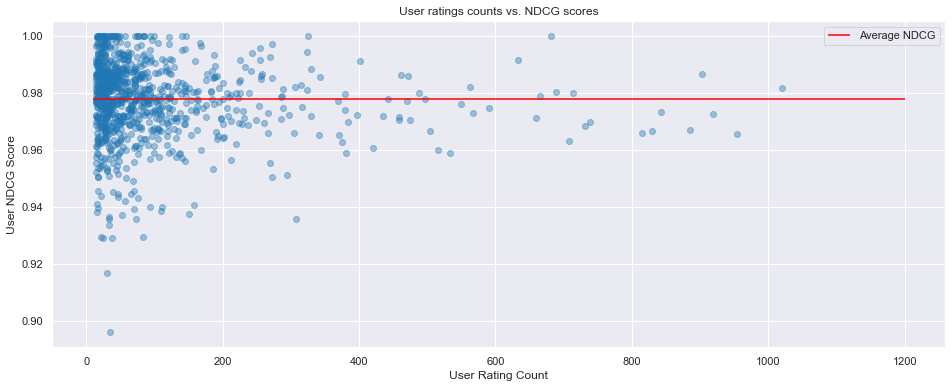

In [116]:
fig, ax = plt.subplots(figsize=(16,6))
plt.scatter(counts_best_model, ndcg_best_model, alpha=.4)
ax.set_title('User ratings counts vs. NDCG scores')
ax.set_xlabel('User Rating Count')
ax.set_ylabel('User NDCG Score')
ax.hlines(np.mean(ndcg_best_model), 10, 1200, colors='r', label='Average NDCG')
ax.legend();

This is generally expected, that as users increase their rating count and have a more 'mature' user profile, the NDCG scores quickly converge into the average NDCG scores around .97-.98

There are many more outliers on the low end, but after reaching 50/100/150 ratings, the scores quickly converge into the average, with only one user with >200 ratins having a score below .95

*********************
<a id="imp"></a>

# 3. Implementation
[Back to Top](#top) | [Previous Section](#model) | [Next Section](#conclusion)

* Build full model with all user data
    * Basic rec's - given id or random - get and display x number of top movie rec's
    * Subset by genre
    * Subset by decade
    * Subset by popularity (most ratings, or very few but good ratings (hidden gems))
* On-boarding function
    * Present movies for rating (or simulated watching)
    * Allow selecting genre / decade
    * Create new model with new user data after a certain threshold
    * Generate rec's as before

## 3.1 Basic Recommendations

* First I'll build the model using the entire dataset, then create a function that will generate recommendations for a given or random userId.

### Setup

In [117]:
best_model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",\
                rank=100, regParam=0.01, maxIter=20).fit(ratings_full)

In [118]:
ratings_full_df = ratings_full.toPandas()

In [119]:
final_movies = pd.read_csv('./data/movies_final.csv')
final_movies['year'] = [int(str(title[-5:-1])) for title in list(final_movies.copy().title)]
final_movies['genres'] = [[genre.lower() for genre in genres.split('|')] for genres in final_movies['genres']]
final_movies = final_movies[['movieId','title','genres','year']]

In [120]:
# Helper function to get a movie's title from its movieId

def get_movie_title(movie_id, movie_title_df):
    return list(movie_title_df[movie_title_df['movieId']==movie_id]['title'])[0]

In [121]:
users = ratings_full.select(best_model.getUserCol()).distinct()

In [122]:
users.take(1)

[Row(userId=128389)]

In [123]:
final_movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",1995
1,2,Jumanji (1995),"[adventure, children, fantasy]",1995
2,3,Grumpier Old Men (1995),"[comedy, romance]",1995
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]",1995
4,5,Father of the Bride Part II (1995),[comedy],1995


In [124]:
get_movie_title(1, final_movies)

'Toy Story (1995)'

### 3.1.1 Vanilla Recommendations

In [125]:
# Vanilla recommendations - returns (default) 5 movies, along with its movieId and predicted ranking.

def get_recs_vanilla(users_df, model, userId, seed=1, n_recs=5):
    if not userId:
        all_users = list(user[0] for user in users.collect())
        np.random.seed(seed)
        userId = int(np.random.choice(all_users))
    recs = model.recommendForUserSubset(users_df.where(users_df.userId==userId), n_recs)\
                    .take(1)[0]['recommendations']
    results = []
    for i in range(len(recs)):
        results.append((recs[i][0], get_movie_title(recs[i][0], final_movies), recs[i][1]))
    return results

In [126]:
get_recs_vanilla(users, best_model, 128389)

[(6016, 'City of God (Cidade de Deus) (2002)', 5.270761013031006),
 (318, 'Shawshank Redemption, The (1994)', 5.204327583312988),
 (1197, 'Princess Bride, The (1987)', 5.071750640869141),
 (1198,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
  5.024830341339111),
 (1997, 'Exorcist, The (1973)', 5.024727821350098)]

In [127]:
get_recs_vanilla(users, best_model, False, seed=45)

[(3949, 'Requiem for a Dream (2000)', 5.269172191619873),
 (111, 'Taxi Driver (1976)', 5.075186729431152),
 (1233, 'Boot, Das (Boat, The) (1981)', 5.0717010498046875),
 (1997, 'Exorcist, The (1973)', 5.028144359588623),
 (1136, 'Monty Python and the Holy Grail (1975)', 5.021001815795898)]

### 3.1.2 Categorical Recommendations

In [128]:
# Generate recommendations based on a given genre or decade

def get_recs_categorical(users_df, model, userId, genre=False, decade=False, seed=1, n_recs=5):
    if not userId:
        all_users = list(user[0] for user in users.collect())
        np.random.seed(seed)
        userId = int(np.random.choice(all_users))
    
    recs = model.recommendForUserSubset(users_df.where(users_df.userId==userId), 2000)\
                    .take(1)[0]['recommendations']
    results_all = []
    for i in range(len(recs)):
        results_all.append((recs[i][0], get_movie_title(recs[i][0], final_movies), recs[i][1]))
    
    results_genre = []
    
    if genre:
        for i in range(len(results_all)):
            this_genres = list(final_movies[final_movies['title']==results_all[i][1]]['genres'])[0]
            if genre in this_genres:
                results_genre.append(results_all[i])
        results_all = results_genre
        
    results_decade = []
    
    if decade:
        for i in range(len(results_all)):
            this_year = list(final_movies[final_movies['title']==results_all[i][1]]['year'])[0]
            this_decade = int(str(this_year)[:-1]+'0')
            if decade == this_decade:
                results_decade.append(results_all[i])
        results_all = results_decade
    return results_all[:n_recs]

In [129]:
get_recs_categorical(users, best_model, 128389, genre='romance')

[(1197, 'Princess Bride, The (1987)', 5.071750640869141),
 (933, 'To Catch a Thief (1955)', 4.99904727935791),
 (3699, 'Starman (1984)', 4.985323429107666),
 (912, 'Casablanca (1942)', 4.983356952667236),
 (3361, 'Bull Durham (1988)', 4.973784923553467)]

In [130]:
get_recs_categorical(users, best_model, 128389, decade=1980, n_recs=5)

[(1197, 'Princess Bride, The (1987)', 5.071750640869141),
 (1198,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
  5.024830341339111),
 (1217, 'Ran (1985)', 5.009511947631836),
 (1261, 'Evil Dead II (Dead by Dawn) (1987)', 5.005512237548828),
 (3699, 'Starman (1984)', 4.985323429107666)]

In [131]:
get_recs_categorical(users, best_model, 128389, genre='comedy', decade=1960, n_recs=5)

[(2078, 'Jungle Book, The (1967)', 4.868485927581787),
 (1247, 'Graduate, The (1967)', 4.792845726013184),
 (750,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
  4.205185413360596),
 (2015, 'Absent-Minded Professor, The (1961)', 3.991806983947754),
 (674, 'Barbarella (1968)', 3.9770374298095703)]

### 3.1.3 'Hidden Gem' Recommendations

In [132]:
# Generate recommendations that have less ratings than a threshold (default=15)

def get_recs_gems(users_df, model, userId, seed=1, n_recs=5, threshold=15):
    if not userId:
        all_users = list(user[0] for user in users.collect())
        np.random.seed(seed)
        userId = int(np.random.choice(all_users))
    
    recs = model.recommendForUserSubset(users_df.where(users_df.userId==userId), 4000)\
                    .take(1)[0]['recommendations']
    results_all = []
    for i in range(len(recs)):
        results_all.append((recs[i][0], get_movie_title(recs[i][0], final_movies), recs[i][1]))
    
    results_gems = []
    
    for i in range(len(recs)):
        if len(ratings_full_df[ratings_full_df['movieId']==recs[i][0]]) < threshold:
            results_gems.append(results_all[i])
    return results_gems[:n_recs]

In [133]:
get_recs_gems(users, best_model, False, n_recs=5)

[(2130, 'Atlantic City (1980)', 4.954793453216553),
 (4234, 'Tailor of Panama, The (2001)', 4.94966983795166),
 (2757, 'Frances (1982)', 4.032136917114258),
 (3516, 'Bell, Book and Candle (1958)', 4.0120415687561035),
 (2070, 'Tender Mercies (1983)', 4.0046916007995605)]

## 3.2 New Users

The goal here is to get a user to a point where their user profile is large enough to be 'usable' - 20 ratings. 'Usable' means that their profile can be folded into the overall model, and thus tailored recommendations can be made using collaborative filtering.

Until that point, we need a way to present films the user might want to watch. We can also offer an option to select any film they've already seen, and rate it immediately.

* Framework for onboarding new Users:
    * Make it clear to the user that they need to rate 20 films before the full recommendation engine kicks in
        * This can be gamified with reminders upon opening the app, or after stopping or finishing a film
    * Plain recommendations
        * Highest rated
        * A mix of high- and moderate-rating-count films, so they don't just get all the most popular films
        * Randomized so that they see different recommendations every time
    * Categorical recommendations
        * Based on user-selected genres, decades, or hidden-gem status
    * Before 20 ratings are achieved:
        * Recommend similar films based on already-watched films and ratings

### 3.2.1 Preparation for Content-Based Filtering

* I will create a 'bag of words' for each movie in this dataset:
    * This will contain all the genres, all the words from its tags, and the year it was made.
    * Similarity will be calculated with a straightforward CountVectorizer and CosineSimilarity approach

In [134]:
unique_genres = set()
for genres in list(final_movies['genres']):
    for genre in genres:
        unique_genres.add(genre)
        
unique_genres

{'(no genres listed)',
 'action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'film-noir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'thriller',
 'war',
 'western'}

In [135]:
tags_full = pd.read_csv('./data/full/tags.csv')

In [136]:
tags_full['tag'] = [str(tag).lower() for tag in list(tags_full['tag'])]

In [137]:
final_tags = tags_full[tags_full['movieId'].isin(list(final_movies['movieId']))]

In [138]:
final_tags.head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [139]:
tags = []

for movieId in final_movies['movieId']:
    bag = []
    for tag in final_tags[final_tags['movieId']==movieId]['tag']:
        bag += list(tag.split())
    bag += final_movies[final_movies['movieId']==movieId]['genres'].values[0]
    decade = (str(final_movies[final_movies['movieId']==movieId]['year'].values[0])[:-1] + '0')
    if movieId == 1:
        print(decade)
    bag += [decade]
    tags.append(" ".join(list(set(bag))))
final_movies['tags'] = tags

1990


In [140]:
final_movies.head(5)

,movieId,title,genres,year,tags
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",1995,rotten feel-good acting cute hanks cowboy buzz...
1,2,Jumanji (1995),"[adventure, children, fantasy]",1995,(best in scary horror book itaege also:zathura...
2,3,Grumpier Old Men (1995),"[comedy, romance]",1995,deutch best comedy velhinhos howard soundtrack...
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]",1995,single chick comedy flick characters based on ...
4,5,Father of the Bride Part II (1995),[comedy],1995,confidence midlife under comedy remake diane m...


### 3.2.2 Building the Matrix

In [141]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [142]:
# instantiating and generating the count matrix
count = CountVectorizer()

count_matrix = count.fit_transform(final_movies['tags'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [143]:
def content_based_recommendations(movieId, movies_df, cosine_sim, n_recs=15, dont_return=[]):
    
    recommended_movies = []
    
    movies_df = movies_df.copy()
    movies_df = movies_df[-movies_df['movieId'].isin(dont_return)]
    
    # getting the index of the movie that matches the movieId
    idx = movies_df[movies_df['movieId']==movieId].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the n most similar movies (skipping the first, which is the movie itself)
    top_n_indexes = list(score_series.iloc[1:(n_recs+1)].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_n_indexes:
        recommended_movies.append(movies_df.iloc[i]['title'])
    
    return recommended_movies

In [144]:
# Checking content-based recommendation results for the first 5 movies in the movies DF

for i in range(1,6):
    print("Top recommendations for:", final_movies[final_movies['movieId']==i].title.values[0])
    display(content_based_recommendations(i, final_movies, cosine_sim))
    print("\n")

Top recommendations for: Toy Story (1995)


['Toy Story 2 (1999)',
 'Finding Nemo (2003)',
 'Monsters, Inc. (2001)',
 'Pinocchio (1940)',
 'Incredibles, The (2004)',
 'Beauty and the Beast (1991)',
 'Cars (2006)',
 'Princess Bride, The (1987)',
 'Back to the Future (1985)',
 'How to Train Your Dragon (2010)',
 'WALL·E (2008)',
 'Lion King, The (1994)',
 'Toy Story 3 (2010)',
 'Star Wars: Episode IV - A New Hope (1977)',
 "Bug's Life, A (1998)"]



Top recommendations for: Jumanji (1995)


["Gulliver's Travels (1939)",
 'Honey, I Shrunk the Kids (1989)',
 'Jungle Book, The (1994)',
 'NeverEnding Story II: The Next Chapter, The (1990)',
 'Jurassic Park (1993)',
 'Peter Pan (2003)',
 'Mary Poppins (1964)',
 'Invisible Man, The (1933)',
 'Harry Potter and the Chamber of Secrets (2002)',
 'James and the Giant Peach (1996)',
 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)',
 'Witches, The (1990)',
 'Where the Wild Things Are (2009)',
 "Dr. Seuss' The Lorax (2012)",
 'Meet the Robinsons (2007)']



Top recommendations for: Grumpier Old Men (1995)


['Grumpy Old Men (1993)',
 'Dennis the Menace (1993)',
 'Kissing a Fool (1998)',
 'Booty Call (1997)',
 'If Lucy Fell (1996)',
 'Getting Even with Dad (1994)',
 'Brothers McMullen, The (1995)',
 'Speechless (1994)',
 'Friends & Lovers (1999)',
 'Jimmy Hollywood (1994)',
 'Boomerang (1992)',
 'Mister Roberts (1955)',
 'Father of the Bride Part II (1995)',
 'Odd Couple, The (1968)',
 'The Intern (2015)']



Top recommendations for: Waiting to Exhale (1995)


['Fluke (1995)',
 'Joy Luck Club, The (1993)',
 'Kissing a Fool (1998)',
 'Scarlet Letter, The (1995)',
 'Friends & Lovers (1999)',
 'How to Make an American Quilt (1995)',
 'Something to Talk About (1995)',
 'Bridges of Madison County, The (1995)',
 'Jeffrey (1995)',
 'Losing Isaiah (1995)',
 'Emma (1996)',
 'Mansfield Park (1999)',
 'Enchanted April (1992)',
 'Jimmy Hollywood (1994)',
 'Three Musketeers, The (1993)']



Top recommendations for: Father of the Bride Part II (1995)


['Father of the Bride (1991)',
 'Rugrats Movie, The (1998)',
 'Parenthood (1989)',
 'Father of the Bride (1950)',
 'Man with Two Brains, The (1983)',
 "Ulee's Gold (1997)",
 "Look Who's Talking Too (1990)",
 'Home Alone 2: Lost in New York (1992)',
 'Mr. Wrong (1996)',
 'Welcome to the Dollhouse (1995)',
 'Ace Ventura: When Nature Calls (1995)',
 'Runaway Bride (1999)',
 'Very Brady Sequel, A (1996)',
 'Baby Geniuses (1999)',
 'Unstrung Heroes (1995)']

## 3.3 Simulating a New User Experience

* Here I will simulate a new user's onboarding experience. This will use 3 phases: new users with 0 ratings, immature user profiles with 1-19 ratings, and new users with mature profiles of 20 ratings.
* After every film is chosen, the user provides a rating from 0.5 - 5.0.


* Phase 1
    * No ratings:
        * Provide a shuffled selection of top (most-reviewed) films
            * All films
            * Genre
            * Decade
            * Hidden Gems
            
            
* Phase 2
    * 1-19 Ratings
        * Provide option for content-based filtering to generate top films
            * Based on the top rated film (or a random choice of the top rated films)
            
            
* Phase 3
    * 20 Ratings
        * User's profile is added to the full collaborative filtering model
        * All films' ratings are predicted
        * The user can get 5 recommended films from:
            * All films
            * Genre
            * Decade
            * Hidden Gems

In [145]:
def new_user_experience(ratings_df, movies_df, seed=1, n_recs=5, n_ratings=5, userId=300000):
    df = ratings_df.select(['userId', 'movieId', 'rating'])
    ratings = []
    df_df = df.toPandas()
    movies_df = movies_df.copy()
    movies_df['decade'] = movies_df['year'].apply(lambda year: int(str(year)[:-1]+'0'))
    
    uniq_movies = list(movies_df['movieId'])
    movies_df['avg_rating'] = [np.mean(df_df[df_df['movieId'] == Id]['rating']) for Id in uniq_movies]
    movies_df['count'] = [len(df_df[df_df['movieId']==movieId]) for movieId in uniq_movies]
    
    dumb_df = movies_df.copy()
    cbf_df = movies_df.copy()
    
    unique_genres = set()
    for genres in list(movies_df['genres']):
        for genre in genres:
            unique_genres.add(genre)
    unique_genres = sorted(list(unique_genres))
    
    unique_decades = set()
    for decade in list(movies_df['decade']):
        unique_decades.add(int(decade))
    unique_decades = sorted(list(unique_decades))
            
    def get_recs(genre=False, decade=False, gems=False):
        top_films = dumb_df.sort_values(by='count', ascending=False)
        top_ids = list(top_films['movieId'])
        if genre:
            movie_ids = []
            for Id in top_ids:
                if genre in list(top_films[top_films['movieId']==Id]['genres'])[0]:
                    movie_ids.append(Id)
            return np.random.choice(list(top_films[top_films['movieId'].isin(movie_ids)]\
                                         .iloc[:100]['title']), n_recs, replace=False)
        if decade:
            decade = int(decade)
            return np.random.choice(list(top_films[top_films['decade']==decade]\
                                         .iloc[:n_recs]['title']), n_recs, replace=False)
        if gems:
            top_films = dumb_df[dumb_df['count'] < 10].sort_values(by='avg_rating', ascending=False)
            top_titles = list(top_films.iloc[:100]['title'])
            return np.random.choice(top_titles, n_recs, replace=False)
        return np.random.choice(list(top_films.iloc[:100]['title']), n_recs, replace=False)
    
    rec_options = [str(x) for x in range(n_recs)]
    decade_options = [str(x) for x in range(len(unique_decades))]
    
    i = 0
    while i < n_ratings:
        this_movie = ''
        if i == 0:
            print('Welcome to FlixWeb!')
        print('Please select an option:')
        response1 = '0'
        if i:
            response1 = input('Do you want (0) General, or (1) Personalized Recommendations?')
            while response1 not in ['0', '1']:
                response1 = input('Do you want (0) General, or (1) Personalized Recommendations?')
        if response1 == '0':
            print('1 - Top Films')
            print('2 - Select a Genre')
            print('3 - Select a Decade')
            print('4 - See Hidden Gems')
            response2 = input("Please select 1-4:")
            while response2 not in ['1','2','3','4']:
                response2 = input("Please select 1-4:")
            if response2 == '1':
                recs = get_recs()
                for rec in enumerate(recs):
                    print(f'{rec[0]}:', rec[1])
                response3 = input('Which movie would you like to watch?')
                while response3 not in rec_options:
                    response3 = input('Which movie would you like to watch?')
                this_movie = recs[int(response3)]
            if response2 == '2':
                for genre in enumerate(unique_genres):
                    print(f"{genre[0]}", genre[1])
                response3 = input('Which genre?')
                while int(response3) not in list(range(len(unique_genres))):
                    response3 = input('Which genre?')
                recs = get_recs(genre=unique_genres[int(response3)])
                for rec in enumerate(recs):
                    print(f'{rec[0]}:', rec[1])
                response4 = input('Which movie would you like to watch?')
                while response4 not in rec_options:
                    response4 = input('Which movie would you like to watch?')
                this_movie = recs[int(response4)]
            if response2 == '3':
                for decade in enumerate(sorted(unique_decades)):
                    print(f"{decade[0]}", decade[1])
                response3 = input('Which decade?')
                while response3 not in decade_options:
                    response3 = input('Which decade?')
                recs = get_recs(decade=unique_decades[int(response3)])
                for rec in enumerate(recs):
                    print(f'{rec[0]}:', rec[1])
                response4 = input('Which movie would you like to watch?')
                while response4 not in rec_options:
                    response4 = input('Which movie would you like to watch?')
                this_movie = recs[int(response4)]
            if response2 == '4':
                recs = get_recs(gems=True)
                for rec in enumerate(recs):
                    print(f'{rec[0]}:', rec[1])
                response3 = input('Which movie would you like to watch?')
                while response3 not in rec_options:
                    response3 = input('Which movie would you like to watch?')
                this_movie = recs[int(response3)]
                
        if response1 == '1':
            best_rating = 0
            basis_ids = []
            
            for (x, y, z) in ratings:
                if z >= best_rating:
                    best_rating = z
                    basis_ids.append(y)
            basis_id = np.random.choice(basis_ids)
            
            already_seen = [y for (x, y, z) in ratings if y != basis_id]
            
            basis_title = list(cbf_df[cbf_df['movieId']==int(basis_id)]['title'])
            
            print(f"Because you liked {basis_title}, we suggest:")
            
            recs = content_based_recommendations(basis_id, cbf_df, cosine_sim, n_recs=n_recs,\
                                                dont_return=already_seen)
            for rec in enumerate(recs):
                print(f'{rec[0]}:', rec[1])
            response3 = input('Which movie would you like to watch?')
            while response3 not in rec_options:
                response3 = input('Which movie would you like to watch?')
            this_movie = recs[int(response3)]
                
        print('What did you think? Please rate from 0.5 - 5.0')
        for val in enumerate([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]):
            print(f"{val[0]}: {val[1]}")
        rating = int(input("What rating?"))
        while rating not in range(10):
            rating = int(input("What rating?"))
        this_movieId = list(movies_df[movies_df['title']==this_movie]['movieId'])[0]
        ratings.append((userId, this_movieId, (int(rating) + 1) /2))
        dumb_df = dumb_df[dumb_df['movieId']!=this_movieId]
        i += 1
        
    print('Full profile achieved!')
    print('Adding your profile to the model...')
    
    columns = ['userId', 'movieId', 'rating']
    df2 = spark.createDataFrame(ratings, columns)
    df3 = df.union(df2)
    
    model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",\
                    rank=100, regParam=0.01, maxIter=20).fit(df3)
    print('Generating your recommendations...')
    top_recs = get_recs_vanilla(df3, model, userId, n_recs=4000)
    rec_stats = {'movieId':[], 'title':[], 'rating':[], 'decade':[], 'count':[]}
    for genre in unique_genres:
        rec_stats[genre] = []
    for rec in top_recs:
        rec_stats['movieId'].append(rec[0])
        rec_stats['title'].append(rec[1])
        rec_stats['rating'].append(rec[2])
        rec_stats['decade'].append(list(movies_df[movies_df['movieId']==rec[0]]['decade'])[0])
        rec_stats['count'].append(list(movies_df[movies_df['movieId']==rec[0]]['count'])[0])
        for genre in unique_genres:
            rec_stats[genre].append(genre in list(movies_df[movies_df['movieId']==rec[0]]['genres'])[0])
    rec_df = pd.DataFrame(rec_stats)
    
    loop = True
    while loop:
        print('What kind of recommendation do you want?')
        print('1 - My Top Films')
        print('2 - Select a Genre')
        print('3 - Select a Decade')
        print('4 - See Hidden Gems')
        print('5 - End Session')
        
        response = input('Please select an option:')
        while response not in ['1','2','3','4','5']:
            response = input("Please select 1-5:")
            
        if response == '1':
            recs = rec_df['title'][:5]
            for rec in enumerate(recs):
                print(f"{rec[0]}: {rec[1]}")
                
        if response == '2':
            for genre in enumerate(unique_genres):
                print(f"{genre[0]}", genre[1])
            response3 = input('Which genre?')
            while int(response3) not in list(range(len(unique_genres))):
                response3 = input('Which genre?')
            genre = unique_genres[int(response3)]
            recs = rec_df[rec_df[genre]]['title'][:5]
            for rec in enumerate(recs):
                print(f"{rec[0]}: {rec[1]}")
            
        if response == '3':
            for decade in enumerate(sorted(unique_decades)):
                print(f"{decade[0]}", decade[1])
            response3 = input('Which decade?')
            while response3 not in decade_options:
                response3 = input('Which decade?')
            decade = int(unique_decades[int(response3)])
            recs = rec_df[rec_df['decade']==decade]['title'][:5]
            for rec in enumerate(recs):
                print(f"{rec[0]}: {rec[1]}")
            
        if response == '4':
            recs = rec_df[rec_df['count']<15]['title'][:5]
            for rec in enumerate(recs):
                print(f"{rec[0]}: {rec[1]}")
            
        if response == '5':
            return 'Thanks for using WebFlix!'
            loop = False

In [146]:
# Let's try it out!

# new_user_experience(ratings_full, final_movies)

In [147]:
# Example interactions/output:

# Welcome to FlixWeb!
# Please select an option:
# 1 - Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# Please select 1-4:1
# 0: Interview with the Vampire: The Vampire Chronicles (1994)
# 1: Speed (1994)
# 2: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
# 3: Die Hard: With a Vengeance (1995)
# 4: Eternal Sunshine of the Spotless Mind (2004)
# Which movie would you like to watch?1
# What did you think? Please rate from 0.5 - 5.0
# 0: 0.5
# 1: 1.0
# 2: 1.5
# 3: 2.0
# 4: 2.5
# 5: 3.0
# 6: 3.5
# 7: 4.0
# 8: 4.5
# 9: 5.0
# What rating?6
# Please select an option:
# Do you want (0) General, or (1) Personalized Recommendations?0
# 1 - Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# Please select 1-4:2
# 0 (no genres listed)
# 1 action
# 2 adventure
# 3 animation
# 4 children
# 5 comedy
# 6 crime
# 7 documentary
# 8 drama
# 9 fantasy
# 10 film-noir
# 11 horror
# 12 imax
# 13 musical
# 14 mystery
# 15 romance
# 16 sci-fi
# 17 thriller
# 18 war
# 19 western
# Which genre?15
# 0: Witness (1985)
# 1: American Pie (1999)
# 2: While You Were Sleeping (1995)
# 3: Little Mermaid, The (1989)
# 4: Postman, The (Postino, Il) (1994)
# Which movie would you like to watch?3
# What did you think? Please rate from 0.5 - 5.0
# 0: 0.5
# 1: 1.0
# 2: 1.5
# 3: 2.0
# 4: 2.5
# 5: 3.0
# 6: 3.5
# 7: 4.0
# 8: 4.5
# 9: 5.0
# What rating?8
# Please select an option:
# Do you want (0) General, or (1) Personalized Recommendations?0
# 1 - Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# Please select 1-4:2
# 0 (no genres listed)
# 1 action
# 2 adventure
# 3 animation
# 4 children
# 5 comedy
# 6 crime
# 7 documentary
# 8 drama
# 9 fantasy
# 10 film-noir
# 11 horror
# 12 imax
# 13 musical
# 14 mystery
# 15 romance
# 16 sci-fi
# 17 thriller
# 18 war
# 19 western
# Which genre?17
# 0: V for Vendetta (2006)
# 1: Usual Suspects, The (1995)
# 2: Few Good Men, A (1992)
# 3: Star Trek II: The Wrath of Khan (1982)
# 4: True Lies (1994)
# Which movie would you like to watch?2
# What did you think? Please rate from 0.5 - 5.0
# 0: 0.5
# 1: 1.0
# 2: 1.5
# 3: 2.0
# 4: 2.5
# 5: 3.0
# 6: 3.5
# 7: 4.0
# 8: 4.5
# 9: 5.0
# What rating?8
# Please select an option:
# Do you want (0) General, or (1) Personalized Recommendations?1
# Because you liked ['Speed (1994)'], we suggest:
# 0: Speed 2: Cruise Control (1997)
# 1: Chain Reaction (1996)
# 2: While You Were Sleeping (1995)
# 3: Independence Day (a.k.a. ID4) (1996)
# 4: Apollo 13 (1995)
# Which movie would you like to watch?3
# What did you think? Please rate from 0.5 - 5.0
# 0: 0.5
# 1: 1.0
# 2: 1.5
# 3: 2.0
# 4: 2.5
# 5: 3.0
# 6: 3.5
# 7: 4.0
# 8: 4.5
# 9: 5.0
# What rating?6
# Please select an option:
# Do you want (0) General, or (1) Personalized Recommendations?1
# Because you liked ['Few Good Men, A (1992)'], we suggest:
# 0: Clockwork Orange, A (1971)
# 1: Once Upon a Time in the West (C'era una volta il West) (1968)
# 2: Gosford Park (2001)
# 3: King of Comedy, The (1983)
# 4: Geronimo: An American Legend (1993)
# Which movie would you like to watch?3
# What did you think? Please rate from 0.5 - 5.0
# 0: 0.5
# 1: 1.0
# 2: 1.5
# 3: 2.0
# 4: 2.5
# 5: 3.0
# 6: 3.5
# 7: 4.0
# 8: 4.5
# 9: 5.0
# What rating?6
# Full profile achieved!
# Adding your profile to the model...
# Generating your recommendations...
# What kind of recommendation do you want?
# 1 - My Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# 5 - End Session
# Please select an option:1
# 0: Godfather, The (1972)
# 1: Pulp Fiction (1994)
# 2: L.A. Confidential (1997)
# 3: Casablanca (1942)
# 4: Rear Window (1954)
# What kind of recommendation do you want?
# 1 - My Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# 5 - End Session
# Please select an option:2
# 0 (no genres listed)
# 1 action
# 2 adventure
# 3 animation
# 4 children
# 5 comedy
# 6 crime
# 7 documentary
# 8 drama
# 9 fantasy
# 10 film-noir
# 11 horror
# 12 imax
# 13 musical
# 14 mystery
# 15 romance
# 16 sci-fi
# 17 thriller
# 18 war
# 19 western
# Which genre?6
# 0: Godfather, The (1972)
# 1: Pulp Fiction (1994)
# 2: L.A. Confidential (1997)
# 3: Chinatown (1974)
# 4: Shawshank Redemption, The (1994)
# What kind of recommendation do you want?
# 1 - My Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# 5 - End Session
# Please select an option:3
# 0 1900
# 1 1910
# 2 1920
# 3 1930
# 4 1940
# 5 1950
# 6 1960
# 7 1970
# 8 1980
# 9 1990
# 10 2000
# 11 2010
# Which decade?7
# 0: Godfather, The (1972)
# 1: Chinatown (1974)
# 2: Godfather: Part II, The (1974)
# 3: One Flew Over the Cuckoo's Nest (1975)
# 4: Taxi Driver (1976)
# What kind of recommendation do you want?
# 1 - My Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# 5 - End Session
# Please select an option:4
# 0: Key Largo (1948)
# 1: Inherit the Wind (1960)
# 2: Last Picture Show, The (1971)
# 3: Hate (Haine, La) (1995)
# 4: Celebration, The (Festen) (1998)
# What kind of recommendation do you want?
# 1 - My Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# 5 - End Session
# Please select an option:2
# 0 (no genres listed)
# 1 action
# 2 adventure
# 3 animation
# 4 children
# 5 comedy
# 6 crime
# 7 documentary
# 8 drama
# 9 fantasy
# 10 film-noir
# 11 horror
# 12 imax
# 13 musical
# 14 mystery
# 15 romance
# 16 sci-fi
# 17 thriller
# 18 war
# 19 western
# Which genre?12
# 0: Dark Knight, The (2008)
# 1: Inception (2010)
# 2: Toy Story 3 (2010)
# 3: Batman Begins (2005)
# 4: Interstellar (2014)
# What kind of recommendation do you want?
# 1 - My Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# 5 - End Session
# Please select an option:2
# 0 (no genres listed)
# 1 action
# 2 adventure
# 3 animation
# 4 children
# 5 comedy
# 6 crime
# 7 documentary
# 8 drama
# 9 fantasy
# 10 film-noir
# 11 horror
# 12 imax
# 13 musical
# 14 mystery
# 15 romance
# 16 sci-fi
# 17 thriller
# 18 war
# 19 western
# Which genre?11
# 0: Silence of the Lambs, The (1991)
# 1: Psycho (1960)
# 2: Alien (1979)
# 3: Sixth Sense, The (1999)
# 4: Shining, The (1980)
# What kind of recommendation do you want?
# 1 - My Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# 5 - End Session
# Please select an option:3
# 0 1900
# 1 1910
# 2 1920
# 3 1930
# 4 1940
# 5 1950
# 6 1960
# 7 1970
# 8 1980
# 9 1990
# 10 2000
# 11 2010
# Which decade?3
# 0: Wizard of Oz, The (1939)
# 1: Snow White and the Seven Dwarfs (1937)
# 2: Duck Soup (1933)
# 3: It Happened One Night (1934)
# 4: Mr. Smith Goes to Washington (1939)
# What kind of recommendation do you want?
# 1 - My Top Films
# 2 - Select a Genre
# 3 - Select a Decade
# 4 - See Hidden Gems
# 5 - End Session
# Please select an option:5
# 'Thanks for using WebFlix!'

*********************
<a id="conclusion"></a>

# 4. Conclusion
[Back to Top](#top) | [Previous Section](#imp)

* I was able to successfully build a collaborative filtering model, and it achieves good metrics of RMSE and NDCG.
    * Once they have 20 ratings, this provides users with recommendations tailored to them, and thus they'll be more likely to find something that looks appealing, and more quickly.
    

* I was also able to build a content-filtering system, that can handle new users with at least one rating.
    * After just one rating, we can provide a basic level of recommendations until their profile matures.
    

* I was able to pull everything together in a mockup function that simulates a user's experience with the service.


## 4.1 Future Work

* Suggest cross-sections of genre/decade, based on user's views and ratings


* Investigate how to better deal with the problem of most films having very few ratings, and thus the most popular and often-rated films seem to be recommended more often
    * This might involve finding a middle ground between the model-generated 'top 5' and the 'hidden gems' category, and weighting popularity to some degree


* Refine the 'tags'/'bag of words' technique used in the content-based function
    * Either use bespoke tagging/metadata (like Pandora) or some selection of data from IMDB or other sources (top few actors' names, keywords, directors' names, etc) to make more accurate connections between films


* Further develop content-based function to be able to provide recommendations based on a group of films, rather than a single recently-viewed film
    * Weighted by rating